<h1>Gaia Star Cluster Hertzsprung Russel Diagrams (HRD)</h1>

Here are some useful links 
- [European Space Agency Gaia Mission - Writing Queries Turorial](https://www.cosmos.esa.int/web/gaia-users/archive/writing-queries)
- [Gaia's Hertzsprung-Russel Diagram](https://sci.esa.int/web/gaia/-/60198-gaia-hertzsprung-russell-diagram)
- [Measuring the Age of a Star Cluster](https://www.e-education.psu.edu/astro801/content/l7_p6.html#:~:text=The%20HR%20diagram%20for%20stage,%2D13%20billion%20years%20old)
- [Astro Prof YouTube Channel Phys 1403](https://www.youtube.com/watch?v=sDds6c7HByg)

**In the examples below we will query open clusters in the Milky way and plot it in a Hertzsprung-Russel Diagram (HRD). We will also attempt to identify the Main Sequence Turnoff points for these star clusters**

*adapted for the Python for Astronomy Course by Chandru Narayan using the material originally develped by Dr. Priya Hasan and the Gaia utilities*

# Steps to create Hertzsprung-Russel Diagram

- Step 1:  Install the required libraries for astronomy data analysis, querying, and plotting.
- Step 2:  Import the necessary modules from the installed libraries.
- Step 3:  Query the Gaia archive for data within a specified radius around a given cluster.
- Step 4a: Create a Dataframe and Cleanup data as needed.
- Step 4b: Calculate absolute magnitudes and colors from the Gaia data.
- Step 5:  Generate HR diagrams, plotting absolute magnitude against color.
- Repeat Steps 3-5 above for another Star Cluster

## Step 1: Install necessary libraries as necessary

In [1]:
# pip install astropy astroquery matplotlib google

## Step 2: Import libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
from astropy.coordinates import SkyCoord
from astroquery.gaia import Gaia
import astropy.coordinates as coord
import pandas as pd

## Step 3: Query Gaia data

### First perform a Google Search about your target

In [3]:
### Setup your target here
target_id = 'M67'
# provide approximate target distance in parsec and target size in minutes for Gaia query
# change default values below
target_dist = 850 # in parsec
target_size = 60 # in minutes

In [4]:
try:
	from googlesearch import search
except ImportError:
	print("No module named 'google' found")

# to search
query = f'{target_id} Wikipedia Astronomy'

for j in search(query, tld="co.in", num=10, stop=10, pause=2):
	print(j)


https://en.wikipedia.org/wiki/Messier_67
https://en.wikipedia.org/wiki/Messier_67#Description
https://en.wikipedia.org/wiki/Messier_67#Planets
https://en.wikipedia.org/wiki/Messier_67#Gallery
https://en.wikipedia.org/wiki/Messier_object
https://en.wikipedia.org/wiki/Charles_Messier
https://en.wikipedia.org/wiki/Deep-sky_object
https://en.wikipedia.org/wiki/Winnecke_4
https://en.wikipedia.org/wiki/Messier_102
https://science.nasa.gov/mission/hubble/science/explore-the-night-sky/hubble-messier-catalog/messier-67/


In [5]:
%%html
<div style="text-align:center;">
<iframe src="https://gea.esac.esa.int/archive/" width="900" height="540"></iframe>
</div>

### Perform your Query

In [6]:
# Parameters for API Query & HRD (20 minutes radius around Cluster center) - Change for each query!
target = target_id # target to query
object_radius = target_size/60 * u.deg # in deg
coordinate = coord.SkyCoord.from_name(target)
print(coordinate)

# Define cluster coordinates and radius for Cone search
radius = object_radius
ra = coordinate.ra
dec = coordinate.dec


<SkyCoord (ICRS): (ra, dec) in deg
    (132.846, 11.814)>


In [7]:
# Query strings for Gaia
# Query 1
query1 = f"""
    SELECT ra, dec, parallax, 1000/parallax as dist, phot_g_mean_mag, bp_rp
    FROM gaiaedr3.gaia_source 
    WHERE parallax > 0 
    AND 1=CONTAINS(
        POINT('ICRS', ra, dec),
        CIRCLE('ICRS', {ra.value}, {dec.value}, {radius.value})
        )
"""
# Query 2
query2 = f"""
    SELECT ra, dec, parallax, 1000/parallax as dist, phot_g_mean_mag, bp_rp
    FROM gaiaedr3.gaia_source 
    WHERE parallax > 0 
    AND bp_rp > -0.75
    AND bp_rp < 6
    AND visibility_periods_used > 8
    AND phot_g_mean_flux_over_error > 50
    AND phot_bp_mean_flux_over_error > 20
    AND phot_rp_mean_flux_over_error > 20
    and phot_bp_rp_excess_factor <
    1.3+0.06*power(phot_bp_mean_mag-phot_rp_mean_mag,2)
    and phot_bp_rp_excess_factor >
    1.0+0.015*power(phot_bp_mean_mag-phot_rp_mean_mag,2)
    and astrometric_chi2_al/(astrometric_n_good_obs_al-5)<
    1.44*greatest(1,exp(-0.4*(phot_g_mean_mag-19.5)))
    AND 1=CONTAINS(
        POINT('ICRS', ra, dec),
        CIRCLE('ICRS', {ra.value}, {dec.value}, {radius.value})
        )
""" 

In [8]:
# create and launch async query
job = Gaia.launch_job_async(query2)
gaia_data = job.get_results()
#print(gaia_data)

INFO: Query finished. [astroquery.utils.tap.core]


## Step 4a: Create a Data Frame & Cleanup Gaia Query Results data

In [9]:
# Create a DataFrame and Cleanup specific to your target:
allstars = gaia_data.to_pandas()
print("allstars\n",allstars)
# filter allstars
allstars.dropna(inplace=True)  # Drop NaN - "not a number"
print("allstars_cleaned\n",allstars)
# filter for dist between 800 & 900 pc (allstars_filtered) by creating a mask
#mask = (allstars.dist >= 800) & (allstars.dist <= 900) & (allstars.bp_rp >= 0.7) & (allstars.bp_rp <= 0.8)
tgt_min_dist = target_dist * 0.9 # create a range
tgt_max_dist = target_dist * 1.1 # create a range
mask = (allstars.dist >= tgt_min_dist) & (allstars.dist <= tgt_max_dist)
allstars = allstars[mask]
print("allstars_masked\n",allstars)

allstars
               ra        dec  parallax         dist  phot_g_mean_mag     bp_rp
0     133.391235  10.987632  0.906051  1103.690840        15.138968  0.925046
1     133.409033  11.001376  0.298192  3353.548674        18.443552  1.123579
2     133.431305  11.020590  0.416756  2399.487620        19.789114  0.762091
3     133.431111  11.015676  1.177280   849.415728        17.560364  2.193853
4     133.403503  11.009986  1.073133   931.850770        18.626163  2.105427
...          ...        ...       ...          ...              ...       ...
8353  131.904787  12.179726  0.830656  1203.867500        14.932704  0.750836
8354  131.917027  12.198130  0.283891  3522.484053        17.067877  0.887508
8355  131.936523  12.219047  0.482473  2072.655652        19.382582  0.625334
8356  131.951450  12.223572  0.572090  1747.975739        14.006058  1.126587
8357  131.924439  12.233467  0.461602  2166.368994        13.469939  1.203620

[8358 rows x 6 columns]
allstars_cleaned
            

## Step 4b: Calculate absolute magnitude and add to DataFrame

### Review Formulas (we drived these in the Star MAgnitudes Module!)
#### The quantity $\boxed{m_{app} - m_{abs}} $ OR $ \boxed {m - M} $ is known as the distance modulus
#### Note that this quantity appears in the equations below to calculate magnitudes and distance
### 1. How to calculate Magnitudes when distance (in pc) is known
#### $$ \boxed{m - M =  5 \times log_{10}(distance) - 5} $$
### 2. How to calculate Magnitudes when parallax (in arc-sec) is known
#### $$ \boxed{m - M =  5 \times log_{10}(1/parallax) - 5} $$
### 3. How to calculate Magnitudes for Gaia calculations when parallax (in milli-arc-sec or 'mas') is known
##### $$ \boxed{m -M = - 5 \times log_{10}(parallax) + 10} $$ OR $$ \boxed{M = m + 5 \times log_{10}(parallax) - 10} $$
#### 4. How to calculate Distance (in pc) when apparent and absolute magnitudes are known
##### $$ \boxed{distance = 10^{\frac{m - M+5}{5}}} $$

In [10]:
# Calculate absolute magnitude with parallax in mas
# Make sure parallax > 0 by creating another filter

distance_modulus = -5 * np.log10(allstars['parallax']) + 10
abs_mag = allstars['phot_g_mean_mag'] - distance_modulus
bp_rp = allstars['bp_rp']

## Step 5: Plot HR diagram

### Simple Plot of HRD with the Sun superimposed

In [11]:
# sun's HRD coordinates values for plotting
#     google "what is bp-rp of the sun" bp-rp = 0.82
bp_rp_sun = 0.82

#     we calculated the abs mag of the sun in the "brightness of stars" project
#     we will do it again below:
sun_app_mag = -27 # very very bright in the sky!
sun_dist_km = 150e6 #km
light_speed = 3e5 #km/s
seconds_in_a_year = 365*24*60*60
light_year_km =  seconds_in_a_year * light_speed
parsec_km = light_year_km * 3.26 #km/pc
sun_dist_pc = sun_dist_km / parsec_km

# Use the magnitude formula above to calculate the absolute magnitude of the Sun
sun_abs_mag = sun_app_mag - 5 * np.log10(sun_dist_pc) + 5
#print(sun_abs_mag)

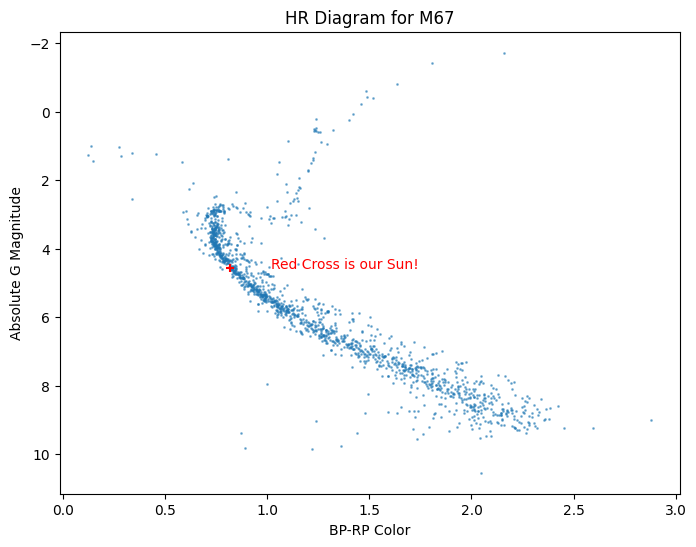

In [12]:
plt.figure(figsize=(8, 6))
plt.scatter(bp_rp, abs_mag, s=1, alpha=0.5) # plot stars
plt.scatter(bp_rp_sun, sun_abs_mag, marker='+', color="red") # plot sun
plt.text(bp_rp_sun+0.2, sun_abs_mag, "Red Cross is our Sun!",  color="red") # mark sun
plt.gca().invert_yaxis()
plt.xlabel("BP-RP Color")
plt.ylabel("Absolute G Magnitude")
plt.title(f"HR Diagram for {target}")
plt.savefig(f"{target}.png", dpi=140)
plt.show()

## Can you tell where the Main Sequence Turnoff is happening?
## What does that tell you about the Age of the cluster?
![](age_turnoff_point.png)
## Answer Questions below

In [52]:
# Write print statement below with your answer
abs_mag_turnoff = 4.0
turnoff_age = 7.1e9
print(f'Main Sequence cutoff for {target} is at Abs Mag {abs_mag_turnoff}')
print(f'This indicates that {target} is {turnoff_age:.1e} years old!')

Main Sequence cutoff for M45 is at Abs Mag 4.0
This indicates that M45 is 7.1e+09 years old!


# Repeat Steps 3 to 5 below for another Star Cluster

## Step 3: Query Gaia data

### First perform a Google Search about your target

In [37]:
### Setup your target here
target_id = 'M45'
# provide approximate target distance in parsec and target size in minutes for Gaia query
# change default values below
target_dist = 136 # in parsec
target_size = 120 # in minutes

In [38]:
try:
	from googlesearch import search
except ImportError:
	print("No module named 'google' found")

# to search
query = f'{target_id} Wikipedia Astronomy'

for j in search(query, tld="co.in", num=10, stop=10, pause=2):
	print(j)


https://upload.wikimedia.org/wikipedia/commons/4/4e/Pleiades_large.jpg?sa=X&ved=2ahUKEwjlod-Ai7qNAxU3JzQIHdvYCXMQ_B16BAgJEAI
https://en.wikipedia.org/wiki/Pleiades
https://simple.wikipedia.org/wiki/Pleiades
https://en.wikipedia.org/wiki/File:M45-_Pleiades_(star_cluster)_(NGC1432).jpg
https://astropixels.com/openclusters/M45-01.html
https://en.wikipedia.org/wiki/Celaeno_(star)
https://en.wikibooks.org/wiki/Messier_Index/M45
http://server1.wikisky.org/starview?object=M45
https://en.wikipedia.org/wiki/Messier_object
https://en.wikipedia.org/wiki/Charles_Messier


In [39]:
%%html
<div style="text-align:center;">
<iframe src="https://gea.esac.esa.int/archive/" width="900" height="540"></iframe>
</div>

### Perform your Query

In [40]:
# Parameters for API Query & HRD (20 minutes radius around Cluster center) - Change for each query!
target = target_id # target to query
object_radius = target_size/60 * u.deg # in deg
coordinate = coord.SkyCoord.from_name(target)
print(coordinate)

# Define cluster coordinates and radius for Cone search
radius = object_radius
ra = coordinate.ra
dec = coordinate.dec


<SkyCoord (ICRS): (ra, dec) in deg
    (56.601, 24.114)>


In [41]:
# Query strings for Gaia
# Query 1
query1 = f"""
    SELECT ra, dec, parallax, 1000/parallax as dist, phot_g_mean_mag, bp_rp
    FROM gaiaedr3.gaia_source 
    WHERE parallax > 0 
    AND 1=CONTAINS(
        POINT('ICRS', ra, dec),
        CIRCLE('ICRS', {ra.value}, {dec.value}, {radius.value})
        )
"""
# Query 2
query2 = f"""
    SELECT ra, dec, parallax, 1000/parallax as dist, phot_g_mean_mag, bp_rp
    FROM gaiaedr3.gaia_source 
    WHERE parallax > 0 
    AND bp_rp > -0.75
    AND bp_rp < 6
    AND visibility_periods_used > 8
    AND phot_g_mean_flux_over_error > 50
    AND phot_bp_mean_flux_over_error > 20
    AND phot_rp_mean_flux_over_error > 20
    and phot_bp_rp_excess_factor <
    1.3+0.06*power(phot_bp_mean_mag-phot_rp_mean_mag,2)
    and phot_bp_rp_excess_factor >
    1.0+0.015*power(phot_bp_mean_mag-phot_rp_mean_mag,2)
    and astrometric_chi2_al/(astrometric_n_good_obs_al-5)<
    1.44*greatest(1,exp(-0.4*(phot_g_mean_mag-19.5)))
    AND 1=CONTAINS(
        POINT('ICRS', ra, dec),
        CIRCLE('ICRS', {ra.value}, {dec.value}, {radius.value})
        )
""" 

In [42]:
# create and launch async query
job = Gaia.launch_job_async(query2)
gaia_data = job.get_results()
#print(gaia_data)

INFO: Query finished. [astroquery.utils.tap.core]


## Step 4a: Create a Data Frame & Cleanup Gaia Query Results data

In [43]:
# Create a DataFrame and Cleanup specific to your target:
allstars = gaia_data.to_pandas()
print("allstars\n",allstars)
# filter allstars
allstars.dropna(inplace=True)  # Drop NaN - "not a number"
print("allstars_cleaned\n",allstars)
# filter for dist between 800 & 900 pc (allstars_filtered) by creating a mask
#mask = (allstars.dist >= 800) & (allstars.dist <= 900) & (allstars.bp_rp >= 0.7) & (allstars.bp_rp <= 0.8)
tgt_min_dist = target_dist * 0.9 # create a range
tgt_max_dist = target_dist * 1.1 # create a range
mask = (allstars.dist >= tgt_min_dist) & (allstars.dist <= tgt_max_dist)
allstars = allstars[mask]
print("allstars_masked\n",allstars)

allstars
               ra        dec  parallax           dist  phot_g_mean_mag  \
0      57.040738  25.202115  2.694236     371.162705        15.228561   
1      57.036437  25.217571  0.003202  312306.424044        18.911062   
2      57.029038  25.220577  0.208152    4804.179551        17.885767   
3      57.036298  25.223672  0.203760    4907.726106        18.500704   
4      57.061629  25.235586  0.937790    1066.336463        18.608236   
...          ...        ...       ...            ...              ...   
41345  56.177253  26.045490  0.460634    2170.919679        17.698112   
41346  56.152010  26.042213  0.936664    1067.618243        16.507923   
41347  56.156221  26.055469  2.952910     338.649035        14.004339   
41348  56.184306  26.049957  0.234163    4270.530701        17.622841   
41349  56.158642  26.068620  0.700025    1428.520492        17.756266   

          bp_rp  
0      1.636703  
1      1.215275  
2      0.956587  
3      0.990368  
4      2.049444  
...  

## Step 4b: Calculate absolute magnitude and add to DataFrame

### Review Formulas (we drived these in the Star MAgnitudes Module!)
#### The quantity $\boxed{m_{app} - m_{abs}} $ OR $ \boxed {m - M} $ is known as the distance modulus
#### Note that this quantity appears in the equations below to calculate magnitudes and distance
### 1. How to calculate Magnitudes when distance (in pc) is known
#### $$ \boxed{m - M =  5 \times log_{10}(distance) - 5} $$
### 2. How to calculate Magnitudes when parallax (in arc-sec) is known
#### $$ \boxed{m - M =  5 \times log_{10}(1/parallax) - 5} $$
### 3. How to calculate Magnitudes for Gaia calculations when parallax (in milli-arc-sec or 'mas') is known
##### $$ \boxed{m -M = - 5 \times log_{10}(parallax) + 10} $$ OR $$ \boxed{M = m + 5 \times log_{10}(parallax) - 10} $$
#### 4. How to calculate Distance (in pc) when apparent and absolute magnitudes are known
##### $$ \boxed{distance = 10^{\frac{m - M+5}{5}}} $$

In [44]:
# Calculate absolute magnitude with parallax in mas
# Make sure parallax > 0 by creating another filter

distance_modulus = -5 * np.log10(allstars['parallax']) + 10
abs_mag = allstars['phot_g_mean_mag'] - distance_modulus
bp_rp = allstars['bp_rp']

## Step 5: Plot HR diagram

### Simple Plot of HRD with the Sun superimposed

In [45]:
# sun's HRD coordinates values for plotting
#     google "what is bp-rp of the sun" bp-rp = 0.82
bp_rp_sun = 0.82

#     we calculated the abs mag of the sun in the "brightness of stars" project
#     we will do it again below:
sun_app_mag = -27 # very very bright in the sky!
sun_dist_km = 150e6 #km
light_speed = 3e5 #km/s
seconds_in_a_year = 365*24*60*60
light_year_km =  seconds_in_a_year * light_speed
parsec_km = light_year_km * 3.26 #km/pc
sun_dist_pc = sun_dist_km / parsec_km

# Use the magnitude formula above to calculate the absolute magnitude of the Sun
sun_abs_mag = sun_app_mag - 5 * np.log10(sun_dist_pc) + 5
#print(sun_abs_mag)

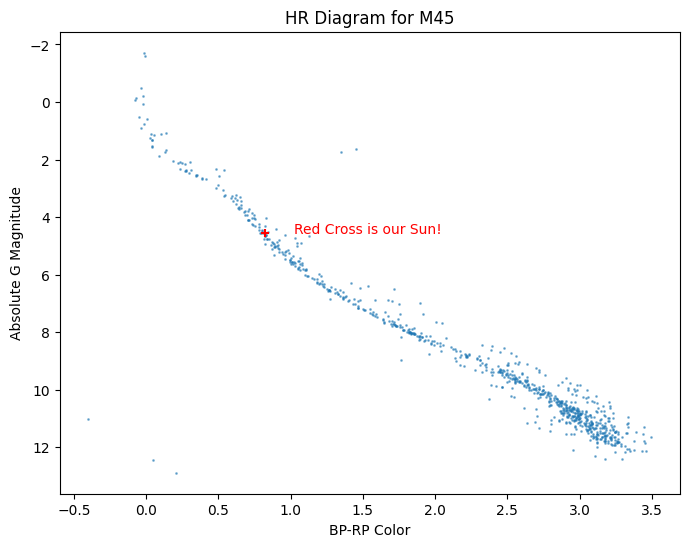

In [46]:
plt.figure(figsize=(8, 6))
plt.scatter(bp_rp, abs_mag, s=1, alpha=0.5) # plot stars
plt.scatter(bp_rp_sun, sun_abs_mag, marker='+', color="red") # plot sun
plt.text(bp_rp_sun+0.2, sun_abs_mag, "Red Cross is our Sun!",  color="red") # mark sun
plt.gca().invert_yaxis()
plt.xlabel("BP-RP Color")
plt.ylabel("Absolute G Magnitude")
plt.title(f"HR Diagram for {target}")
plt.savefig(f"{target}.png", dpi=140)
plt.show()

## Can you tell where the Main Sequence Turnoff is happening?
## What does that tell you about the Age of the cluster?
![](age_turnoff_point.png)
## Answer Questions below

In [51]:
# Write print statement below with your answer
abs_mag_turnoff = 1
turnoff_age = 1.6e8
print(f'Main Sequence cutoff for {target} is at Abs Mag {abs_mag_turnoff}')
print(f'This indicates that {target} is approximately {turnoff_age:.1e} years old!')

Main Sequence cutoff for M45 is at Abs Mag 1
This indicates that M45 is approximately 1.6e+08 years old!
